# Difftest Results

Connect to results database:

In [6]:
import sqlalchemy as sql
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from matplotlib.ticker import FuncFormatter
from collections import OrderedDict
from labm8 import viz

%matplotlib inline
sns.set(style="ticks", color_codes=True)
plt.style.use(["seaborn-white", "seaborn-paper"])

import db
from db import *
%run util.py

hostname = "cc1"
db.init(hostname)

'mysql://cc1:3306/project_b'

## Overview

In [10]:
import pandas as pd
from collections import OrderedDict

def get_stats(s, tables, testbed_id, no_opt):
    param_ids = s.query(tables.params.id)\
        .filter(tables.params.optimizations == no_opt)

    generation_time = sql.sql.func.ifnull(tables.programs.runtime, .9)
    runtime = tables.results.runtime
    reduction_time = sql.sql.func.ifnull(tables.reductions.runtime, 0)
    result_time = generation_time + runtime + reduction_time

    q = s.query(sql.sql.func.count(tables.results.id), sql.sql.func.sum(result_time))\
        .outerjoin(tables.programs)\
        .outerjoin(tables.reductions)\
        .filter(tables.results.testbed_id == testbed_id,
                tables.results.params_id.in_(param_ids))
    num_results, total_time = q.first()
    return num_results, total_time


def get_rows(s, testbed_id):
    testbed = s.query(Testbed).filter(Testbed.id == testbed_id).first()
    
    clsmith_noopt_results, clsmith_noopt_time = get_stats(s, CLSMITH_TABLES, testbed_id, True)
    clsmith_results, clsmith_time = get_stats(s, CLSMITH_TABLES, testbed_id, False)

    clgen_noopt_results, clgen_noopt_time = get_stats(s, CLGEN_TABLES, testbed_id, True)
    clgen_results, clgen_time = get_stats(s, CLGEN_TABLES, testbed_id, False)
    
    r1 = OrderedDict()
    r1["Device"] = device_str(testbed.device)
    r1["±"] = "-"
    r1["CLSmith time"] = clsmith_noopt_time
    r1["CLSmith time (hrs)"] = "{:.1f}h".format(clsmith_noopt_time / 3600)
    r1["CLSmith results"] = clsmith_noopt_results
    r1["CLgen time"] = clgen_noopt_time
    r1["CLgen time (hrs)"] = "{:.1f}h".format(clgen_noopt_time / 3600)
    r1["CLgen results"] = clgen_noopt_results
    
    r2 = OrderedDict()
    r2["Device"] = device_str(testbed.device)
    r2["±"] = "+"
    r2["CLSmith time"] = clsmith_time
    r2["CLSmith time (hrs)"] = "{:.1f}h".format(clsmith_time / 3600)
    r2["CLSmith results"] = clsmith_results
    r2["CLgen time"] = clgen_time
    r2["CLgen time (hrs)"] = "{:.1f}h".format(clgen_time / 3600)
    r2["CLgen results"] = clgen_results
    
    return r1, r2


rows = []
with Session(commit=False) as s:
    for config_id, testbed_id in CONFIGURATIONS:
        rows += get_rows(s, testbed_id)
overview_table = pd.DataFrame(rows)
overview_table

,Device,±,CLSmith time,CLSmith time (hrs),CLSmith results,CLgen time,CLgen time (hrs),CLgen results
0,GeForce GTX 1080,-,247018.889571,68.6h,21000,155706.524918,43.3h,60637
1,GeForce GTX 1080,+,224885.826677,62.5h,21000,174607.606870,48.5h,66777
2,GeForce GTX 780,-,205346.184916,57.0h,21000,42861.789235,11.9h,22051
3,GeForce GTX 780,+,189513.348256,52.6h,20051,40781.193549,11.3h,22051
4,Intel HD Haswell GT2,-,415676.334975,115.5h,14887,69255.642820,19.2h,63952
5,Intel HD Haswell GT2,+,192305.828601,53.4h,6957,52907.767079,14.7h,48715
6,Intel E5-2620 v4,-,190422.024907,52.9h,21000,80895.675423,22.5h,61474
7,Intel E5-2620 v4,+,207719.975833,57.7h,21000,96799.003626,26.9h,67651
8,Intel E5-2650 v2,-,241560.881544,67.1h,21000,40536.877543,11.3h,22130
9,Intel E5-2650 v2,+,201940.933873,56.1h,21001,41614.433166,11.6h,22130


# Experimental Setup

### TestBeds

A testbed is a combination of host platform and OpenCL device.

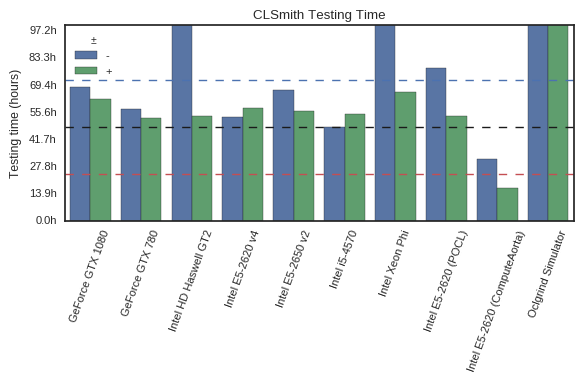

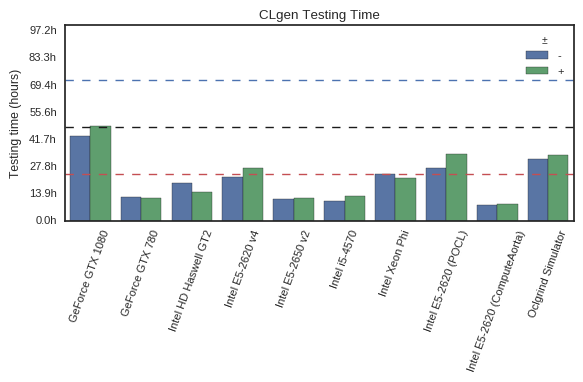

In [8]:
def plot_testing_time(table, time_column, title):
    sns.barplot(x="Device", y=time_column, data=overview_table, hue="±")

    ax = plt.gca()

    # X axis
    plt.setp(ax.get_xticklabels(), rotation=70)  # rotate x ticks
    ax.set_xlabel("")

    # Y axis
    ax.set_ylim((0, 100 * 3600))
    ax.yaxis.set_major_formatter(FuncFormatter(
        lambda x, pos: "{:.1f}h".format(x / 3600)))
    ax.set_ylabel("Testing time (hours)")
    plt.title(title)

    plt.axhline(y=24 * 3600, color="r", lw=1, linestyle="--")
    plt.axhline(y=48 * 3600, color="k", lw=1, linestyle="--")
    plt.axhline(y=72 * 3600, color="b", lw=1, linestyle="--")

    viz.finalise(figsize=(6, 4))

plot_testing_time(overview_table, "CLSmith time", "CLSmith Testing Time")
plot_testing_time(overview_table, "CLgen time", "CLgen Testing Time")

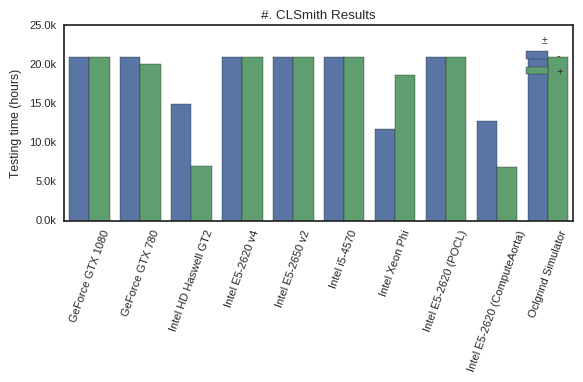

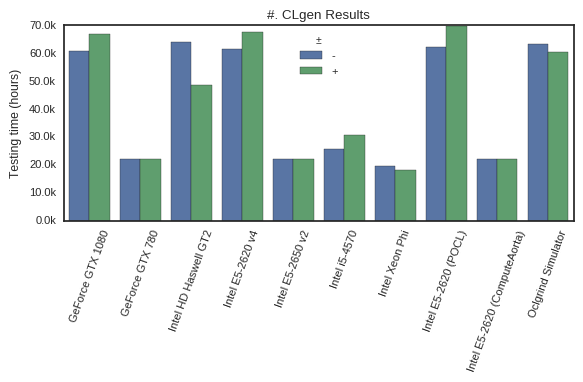

In [9]:
def plot_num_tests(table, time_column, title):
    sns.barplot(x="Device", y=time_column, data=overview_table, hue="±")

    ax = plt.gca()

    # X axis
    plt.setp(ax.get_xticklabels(), rotation=70)  # rotate x ticks
    ax.set_xlabel("")

    # Y axis
    ax.yaxis.set_major_formatter(FuncFormatter(
        lambda x, pos: "{:.1f}k".format(x / 1000)))
    ax.set_ylabel("Testing time (hours)")
    plt.title(title)

    viz.finalise(figsize=(6, 4))

plot_num_tests(overview_table, "CLSmith results", "#. CLSmith Results")
plot_num_tests(overview_table, "CLgen results", "#. CLgen Results")

In [42]:
# push LaTex to Overleaf
!cd ~/docs/paper-project_b/ && git pull --rebase

import os
from collections import OrderedDict


def get_platform_stats(s, testbed: Testbed):
    submitable_results = [coCLgenResult, cl_launcherCLgenResult, CLgenResult]
    def get_submitted(table):
        """ submitted, non-duplicate bugs """
        return s.query(table)\
            .filter(table.testbed_id == testbed.id,
                    table.submitted == 1,
                    table.dupe != 1).count()

    runtime_tables = [coCLgenResult, cl_launcherCLgenResult]  # CLgenResult done separately
    def get_runtime(table):
        return s.query(sql.sql.func.sum(table.runtime)).filter(table.testbed_id == testbed.id).first()[0] or 0

    clgen_time = sum(overview_table.loc[overview_table["Device"] == device_str(testbed.device)]["CLgen time"].values)

    return (
        sum(get_runtime(table) for table in runtime_tables) + clgen_time,
        sum(get_submitted(table) for table in submitable_results),
    )


def get_row(s, config_id, testbed_id):
    testbed = s.query(Testbed).filter(Testbed.id == testbed_id).first()
    d = OrderedDict()
    d["#."] = config_id
    d["Platform"] = platform_str(testbed.platform)
    d["Device"] = device_str(testbed.device)
    d["Driver"] = driver_str(testbed.driver)
    d["OpenCL"] = testbed.opencl
    d["Operating system"] = host_str(testbed.host)
    d["Device type"] = devtype_str(testbed.devtype)
    runtime, submitted = get_platform_stats(s, testbed)
    d["Testing time"] = "{:.0f} hours".format(round(runtime / 3600))
    d["B.R. Submitted"] = submitted
    return d

with Session(commit=False) as s:
    rows = [get_row(s, *x) for x in CONFIGURATIONS]
table = pd.DataFrame(rows)
with open(os.path.expanduser("~/docs/paper-project_b/build/tab/platforms.tex"), "w") as outfile:
    print(f"""\
\\begin{{tabular}}{{ cllllll | rr }}
\\toprule
\\textbf{{\\#. }} & \\textbf{{Platform}} & \\textbf{{Device}} & \\textbf{{Driver}} & \\textbf{{OpenCL}} & 
\\textbf{{Operating system}} & \\textbf{{Device Type}} & \\textbf{{Testing time}} & \\textbf{{Bugs Submitted}} \\\\
\\midrule""", file=outfile)
    for row in rows:
        print(" & ".join([str(x) for x in row.values()]), "\\\\", file=outfile)
    print(f"""
\\bottomrule
\\end{{tabular}}
""", file=outfile)

!cd ~/docs/paper-project_b/build && git add . && git commit -m "auto: build/tab/platforms.tex" && git push
table

remote: Counting objects: 12, done
remote: Finding sources: 100% (8/8)
remote: Total 8 (delta 6), reused 8 (delta 6)
Unpacking objects: 100% (8/8), done.
From https://git.overleaf.com/8608915dsywxshwwjmw
   3827b9b..e4446a5  master     -> origin/master
First, rewinding head to replay your work on top of it...
Fast-forwarded master to e4446a5cee77815d41ea4e652a90f2b423e57d68.
[master a300b04] auto: build/tab/platforms.tex
 1 file changed, 12 insertions(+), 12 deletions(-)
Counting objects: 5, done.
Delta compression using up to 16 threads.
Compressing objects: 100% (5/5), done.
Writing objects: 100% (5/5), 520 bytes | 0 bytes/s, done.
Total 5 (delta 3), reused 0 (delta 0)
remote: Resolving deltas: 100% (3/3)
remote: Updating references: 100% (1/1)
To https://git.overleaf.com/8608915dsywxshwwjmw
   e4446a5..a300b04  master -> master


,#.,Platform,Device,Driver,OpenCL,Operating system,Device type,Testing time,B.R. Submitted
0,1,NVIDIA CUDA,GeForce GTX 1080,375.39,1.2,Ubuntu 16.04 64bit,GPU,99 hours,0
1,2,NVIDIA CUDA,GeForce GTX 780,361.42,1.2,openSUSE 13.1 64bit,GPU,23 hours,0
2,3,Intel Gen OCL Driver,Intel HD Haswell GT2,1.3,1.2,Ubuntu 16.04 64bit,GPU,34 hours,0
3,4,Intel OpenCL,Intel E5-2620 v4,1.2.0.25,2.0,Ubuntu 16.04 64bit,CPU,55 hours,0
4,5,Intel OpenCL,Intel E5-2650 v2,1.2.0.44,1.2,CentOS 7.1 64bit,CPU,28 hours,0
5,6,Intel OpenCL,Intel i5-4570,1.2.0.25,1.2,Ubuntu 16.04 64bit,CPU,23 hours,0
6,7,Intel OpenCL,Intel Xeon Phi,1.2,1.2,CentOS 7.1 64bit,Accelerator,52 hours,0
7,8,POCL,Intel E5-2620 (POCL),0.14,2.0,Ubuntu 16.04 64bit,CPU,66 hours,0
8,9,ComputeAorta,Intel E5-2620 (ComputeAorta),1.14,1.2,Ubuntu 16.04 64bit,CPU,17 hours,0
9,10,Oclgrind,Oclgrind Simulator,16.10,1.2,Ubuntu 16.04 64bit,Emulator,69 hours,0


In [ ]:
%run mkmegatable.ipy

## Runtimes

In [11]:
clgen_generation_time = .9

def get_runtimes():
    TIMEOUT = 60
    
    with Session(commit=False) as s:
        # CLSmith times
        q = s.query(
                CLSmithResult.runtime, 
                CLSmithProgram.runtime, 
                sql.sql.func.ifnull(CLSmithReduction.runtime, 0))\
            .outerjoin(CLSmithProgram)\
            .outerjoin(CLSmithReduction)\
            .filter(CLSmithResult.classification != None)
        clsmith_times = np.array([row for row in q])

        # CLgen times
        q = s.query(
                CLgenResult.runtime,
                sql.sql.func.ifnull(CLgenProgram.runtime, clgen_generation_time) + CLgenHarness.generation_time,
                sql.sql.func.ifnull(CLgenReduction.runtime, 0))\
            .outerjoin(CLgenProgram)\
            .outerjoin(CLgenHarness)\
            .outerjoin(CLgenReduction)\
            .filter(CLgenResult.classification != None)
        clgen_times = np.array([row for row in q])

    table = (
        [("Execution", x, "CLSmith") for x in clsmith_times[:,0] if x < TIMEOUT] +
        [("Generation", x, "CLSmith") for x in clsmith_times[:,1] if x < TIMEOUT] +
        [("Reduction", x, "CLSmith") for x in clsmith_times[:,2] if x > 0] +
        [("Execution", x, "CLgen") for x in clgen_times[:,0] if x < TIMEOUT] +
        [("Generation", x, "CLgen") for x in clgen_times[:,1] if x < TIMEOUT] +
        [("Reduction", x, "CLgen") for x in clgen_times[:,2] if x > 0])
    table = pd.DataFrame(table, columns=["Name", "Runtime (s)", "Source"])
    return table

runtimes_table = get_runtimes()

In [12]:
sns.set(style="ticks")

def plot_runtimes(runtimes_table, *args, **kwargs):
    # Plot
    palette = sns.cubehelix_palette(2, rot=0, light=.75, dark=1)
    ax = sns.boxplot(
        x="Name", y="Runtime (s)", hue="Source", data=table,
        width=.75, linewidth=1, fliersize=.5, whis=np.inf, 
        palette=palette, order=["Generation", "Execution", "Reduction"])

    
       # Y axis
    ax.set_yscale("log", nonposy='clip')
    plt.ylim((0, 10000))

    # X axis
    plt.xlabel("")
    
    # Legend
    ax.get_legend().set_title("")
    plt.legend(loc='upper left')
    ax.get_legend().draw_frame(False)
    
    # Border
    sns.despine(ax=ax)

    viz.finalise(*args, **kwargs)


plot_runtimes(runtimes_table, figsize=(4, 3))

# push LaTex to Overleaf
!cd ~/docs/paper-project_b/ && git pull --rebase
plot_runtimes(clsmith_times, clgen_times, fs.path("~/docs/paper-project_b/build/img/runtimes.pdf"), figsize=(4, 3))
!cd ~/docs/paper-project_b/build && git add . && git commit -m "auto: build/img/runtimes.pdf" && git push

ValueError: Could not interpret input 'Name'

## Kernel sizes

In [ ]:
sns.set(style="ticks")
from collections import defaultdict

def get_kernel_sizes():
    TIMEOUT = 60
    
    with Session(commit=False) as s:
        # CLSmith times
        clsmith = s.query(
                CLSmithResult.classification,
                sql.sql.func.ifnull(CLSmithReduction.src, CLSmithProgram.src))\
            .outerjoin(CLSmithProgram)\
            .outerjoin(CLSmithReduction)\
            .filter(CLSmithResult.classification != None)#,
    #                CLSmithResult.classification != "pass")

        clgen = s.query(
                CLgenResult.classification,
                sql.sql.func.ifnull(CLgenReduction.src, CLgenProgram.src))\
            .outerjoin(CLgenProgram)\
            .outerjoin(CLgenReduction)\
            .filter(CLgenResult.classification != None),
    #                CLgenResult.classification != "pass")
    
    table = (
        [(classification, len(src.split('\n')), "CLSmith") for classification, src in clsmith] +
        [(classification, len(src.split('\n')), "CLgen") for classification, src in clgen])
    
    return pd.DataFrame(table, columns=['Classification', 'Line count', 'Source'])

kernel_sizes_table = get_kernel_sizes()

In [ ]:
def plot_kernel_sizes(table, *args, **kwargs):
    palette = sns.cubehelix_palette(2, rot=0, light=.75, dark=1)
    ax = sns.boxplot(
        x="Classification", y="Line count", hue="Source", data=table,
        width=.75, linewidth=1, fliersize=.5, whis=np.inf, 
        palette=palette, order=["w", "bf", "to"])

    # Y axis
    ax.set_yscale("log", nonposy='clip')
    # plt.ylim((0, 10000))

    # X axis
    plt.xlabel("")
    
    # Legend
    ax.get_legend().set_title("")
    plt.legend(loc='upper left')
    ax.get_legend().draw_frame(False)
    
    # Border
    sns.despine(ax=ax)
    
    viz.finalise(*args, **kwargs)
    
plot_kernel_sizes(kernel_sizes_table, figsize=(4, 3))

# push LaTex to Overleaf
!cd ~/docs/paper-project_b/ && git pull --rebase
plot_kernel_sizes(kernel_sizes_table, fs.path("~/docs/paper-project_b/build/img/kernel-sizes.pdf"), figsize=(4, 3))
!cd ~/docs/paper-project_b/build && git add . && git commit -m "auto: build/img/kernel-sizes.pdf" && git push

## Total time

In [ ]:
def get_totaltimes():
    
    def _t(s, results_table, programs_table, reductions_table):
        generation_time = sql.sql.func.ifnull(programs_table.runtime, clgen_generation_time)
        runtime = results_table.runtime
        reduction_time = sql.sql.func.ifnull(reductions_table.runtime, 0)
        total_time = generation_time + runtime + reduction_time

        q = s.query(total_time)\
            .outerjoin(programs_table)\
            .outerjoin(reductions_table)\
            .filter(results_table.classification != None)\
            .order_by(results_table.date)

        times = np.array([row[0] / 3600 for row in q]).cumsum()
        return times
    
    with Session(commit=False) as s:
        clsmith_times = _t(s, CLSmithResult, CLSmithProgram, CLSmithReduction)
        clgen_times = _t(s, CLgenResult, CLgenProgram, CLgenReduction)

    return clsmith_times, clgen_times

clsmith_times, clgen_times = get_totaltimes()

In [ ]:
def plot_total_tests(clsmith_times, clgen_times, *args, **kwargs):
    
    def thousands(x, pos):
        return "{:.0f}k".format(x / 1000)
    
    ax = plt.gca()
    ax.plot(clsmith_times, range(len(clsmith_times)), label="CLSmith")
    ax.plot(clgen_times, range(len(clgen_times)), label="CLgen")

    ax.set_xlabel("Testing time (hours)")
    ax.set_ylabel("Completed Test cases")
    
    # X axis
    ax.set_xlim((0, 48))
    
    # Y axis
    formatter = FuncFormatter(thousands)
    ax.set_ylim((0, 100000))
    ax.yaxis.set_major_formatter(formatter)
    
    ax.legend()
    ax.get_legend().set_title("")
    plt.legend(loc='upper left')
    ax.get_legend().draw_frame(False)
        
    viz.finalise(*args, **kwargs)

plot_total_tests(clsmith_times, clgen_times, figsize=(4, 3))

# push LaTex to Overleaf
!cd ~/docs/paper-project_b/ && git pull --rebase
plot_total_tests(clsmith_times, clgen_times, fs.path("~/docs/paper-project_b/build/img/total-tests.pdf"), figsize=(4, 3))
!cd ~/docs/paper-project_b/build && git add . && git commit -m "auto: build/img/total-tests.pdf" && git push